<a href="https://colab.research.google.com/github/ever-oli/MLby22/blob/main/FaceRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# =============================================================================
# REAL-TIME FACE DETECTION WITH YUNET AND JAVASCRIPT WEBCAM BRIDGE
# =============================================================================
import cv2
import numpy as np
import base64
import os
import urllib.request
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js

# -----------------------------------------------------------------------------
# 1. Download Pre-trained YuNet Model (ONNX format)
# -----------------------------------------------------------------------------
model_url = "https://github.com/opencv/opencv_zoo/raw/main/models/face_detection_yunet/face_detection_yunet_2023mar.onnx"
model_path = "face_detection_yunet.onnx"

if not os.path.exists(model_path):
    print("Downloading YuNet ONNX model...")
    urllib.request.urlretrieve(model_url, model_path)
    print("Download complete.")

# Initialize the YuNet detector
# We set generic input sizes here; they will be dynamically updated in the loop
yunet = cv2.FaceDetectorYN.create(
    model=model_path,
    config="",
    input_size=(320, 320),
    score_threshold=0.6,
    nms_threshold=0.3,
    top_k=5000,
    backend_id=cv2.dnn.DNN_BACKEND_OPENCV,
    target_id=cv2.dnn.DNN_TARGET_CPU
)

# -----------------------------------------------------------------------------
# 2. Helper Functions for Image Encoding/Decoding
# -----------------------------------------------------------------------------
def js_to_image(js_reply):
    """ Converts the base64 encoded image string from JS into an OpenCV BGR array """
    image_bytes = base64.b64decode(js_reply.split(',')[1])
    jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
    img = cv2.imdecode(jpg_as_np, flags=1)
    return img

def bbox_to_bytes(bbox_array):
    """ Converts OpenCV bounding box image array back to base64 for the browser """
    # Use PNG to preserve transparency (alpha channel)
    _, buffer = cv2.imencode('.png', bbox_array)
    bbox_bytes = base64.b64encode(buffer).decode('utf-8')
    return bbox_bytes

# -----------------------------------------------------------------------------
# 3. JavaScript Webcam Video Stream
# -----------------------------------------------------------------------------
def video_stream():
    js = Javascript('''
        var video;
        var div = null;
        var stream;
        var captureCanvas;
        var imgElement;
        var labelElement;

        var pendingResolve = null;
        var shutdown = false;

        function removeDom() {
           stream.getVideoTracks()[0].stop();
           video.remove();
           div.remove();
           video = null;
           div = null;
           stream = null;
           imgElement = null;
           captureCanvas = null;
           labelElement = null;
        }

        function onAnimationFrame() {
          if (!shutdown) {
            window.requestAnimationFrame(onAnimationFrame);
          }
          if (pendingResolve) {
            var result = "";
            if (!shutdown) {
              captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
              result = captureCanvas.toDataURL('image/jpeg', 0.8)
            }
            var lp = pendingResolve;
            pendingResolve = null;
            lp(result);
          }
        }

        async function createDom() {
          if (div !== null) {
            return stream;
          }
          div = document.createElement('div');
          div.style.border = '2px solid black';
          div.style.padding = '3px';
          div.style.width = '646px'; // Fixed width to match 640px video + 2*3px padding
          div.style.height = '530px'; // Fixed height (480px video + ~22px status + 20px instruction + 2*3px padding)
          div.style.position = 'relative'; // Important for absolute positioning of imgElement
          document.body.appendChild(div);

          const modelOut = document.createElement('div');
          modelOut.innerHTML = "<span>Status:</span>";
          labelElement = document.createElement('span');
          labelElement.innerText = 'Initializing...';
          labelElement.style.fontWeight = 'bold';
          modelOut.appendChild(labelElement);
          div.appendChild(modelOut);

          video = document.createElement('video');
          video.style.display = 'block';
          video.width = 640; // Fixed width
          video.height = 480; // Fixed height
          video.setAttribute('playsinline', '');
          video.onclick = () => { shutdown = true; };
          stream = await navigator.mediaDevices.getUserMedia(
              {video: { facingMode: "user"}});
          div.appendChild(video);

          imgElement = document.createElement('img');
          imgElement.style.position = 'absolute';
          imgElement.style.zIndex = 1; // Ensure it's above the video
          imgElement.style.top = '28px'; // Adjust top to be below the status text, aligned with video (approx. status div height + div padding)
          imgElement.style.left = '3px'; // Adjust left to account for div padding
          imgElement.width = 640; // Fixed width
          imgElement.height = 480; // Fixed height
          imgElement.onclick = () => { shutdown = true; };
          div.appendChild(imgElement);

          const instruction = document.createElement('div');
          instruction.innerHTML = '<span style="color: red; font-weight: bold;">Click on the video to stop the script.</span>';
          div.appendChild(instruction);

          video.srcObject = stream;
          await video.play();

          captureCanvas = document.createElement('canvas');
          captureCanvas.width = 640;
          captureCanvas.height = 480;
          window.requestAnimationFrame(onAnimationFrame);

          return stream;
        }
        async function stream_frame(label, imgData) {
          if (shutdown) {
            removeDom();
            shutdown = false;
            return '';
          }
          var preCreate = Date.now();
          stream = await createDom();

          var preShow = Date.now();
          if (label !== "") {
            labelElement.innerHTML = label;
          }
          if (imgData !== "") {
            // Use PNG to support transparency
            imgElement.src = "data:image/png;base64," + imgData;
          }

          var preCapture = Date.now();
          var result = await new Promise(function(resolve, reject) {
            pendingResolve = resolve;
          });
          shutdown = false;
          return {'create': preShow - preCreate,
                  'show': preCapture - preShow,
                  'capture': Date.now() - preCapture,
                  'img': result};
        }
    ''')
    display(js)

# -----------------------------------------------------------------------------
# 4. Main Processing Loop
# -----------------------------------------------------------------------------
def video_frame(label, bbox):
    data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
    return data

# Start the stream
video_stream()
label_html = 'Capturing...'
bbox_bytes = ''

print("Stream started. Click the video output to stop.")

while True:
    # Fetch the next frame from the Javascript callback
    js_reply = video_frame(label_html, bbox_bytes)

    # Check if the JS stream has stopped (returns an empty string)
    # or if the image data itself is empty, indicating a problem or shutdown
    if not js_reply or (isinstance(js_reply, dict) and not js_reply.get("img")):
        print("Received empty JS reply or empty image data, stopping stream.")
        break

    # Convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # Create a transparent overlay to draw bounding boxes on
    bbox_array = np.zeros([480, 640, 4], dtype=np.uint8)

    # Update YuNet input size to match the webcam frame
    h, w, _ = img.shape
    yunet.setInputSize((w, h))

    # Detect faces
    _, faces = yunet.detect(img)

    if faces is not None:
        for face in faces:
            # YuNet returns bounding box (x, y, w, h) and 5 facial landmarks
            box = list(map(int, face[:4]))
            color = (0, 255, 0, 255) # Green with full alpha
            thickness = 2

            # Draw the bounding box on the transparent overlay
            cv2.rectangle(bbox_array, (box[0], box[1]), (box[0]+box[2], box[1]+box[3]), color, thickness)

            # Optional: Draw the 5 landmarks (eyes, nose, mouth corners)
            # This is crucial for aligning faces before passing them to ArcFace
            landmarks = list(map(int, face[4:14]))
            for i in range(5):
                cv2.circle(bbox_array, (landmarks[2*i], landmarks[2*i+1]), 2, (0, 0, 255, 255), -1)

    # Convert the overlay array back to base64 so JS can render it over the video
    bbox_bytes = bbox_to_bytes(bbox_array)

print("Stream stopped.")

<IPython.core.display.Javascript object>

Stream started. Click the video output to stop.
Received empty JS reply or empty image data, stopping stream.
Stream stopped.


Face aligned and extracted successfully. Shape: (112, 112, 3)


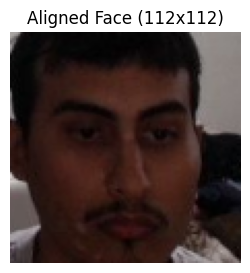

In [11]:
# =============================================================================
# FACE ALIGNMENT AND EXTRACTION (AFFINE TRANSFORMATION)
# =============================================================================
import matplotlib.pyplot as plt

# 1. Define the standard reference points for a 112x112 cropped face.
# These represent the mathematically ideal pixel coordinates for the
# left eye, right eye, nose, left mouth corner, and right mouth corner.
# (This specific layout is the standard for ArcFace and many modern models).
standard_landmarks = np.array([
    [38.2946, 51.6963],
    [73.5318, 51.5014],
    [56.0252, 71.7366],
    [41.5493, 92.3655],
    [70.7299, 92.2041]
], dtype=np.float32)

def align_face(image, face_data):
    """
    Takes the raw image and the YuNet face data, calculates the transformation
    matrix, and returns a perfectly cropped 112x112 face.
    """
    # Extract the 5 landmarks (indices 4 through 13) and reshape into a 5x2 matrix
    detected_landmarks = np.array(face_data[4:14]).reshape(5, 2).astype(np.float32)

    # Calculate the Affine Transformation Matrix (M)
    # This finds the optimal rotation and scaling to match our standard_landmarks
    M, _ = cv2.estimateAffinePartial2D(detected_landmarks, standard_landmarks)

    # Apply the matrix to the original image, outputting a 112x112 crop
    aligned_face = cv2.warpAffine(image, M, (112, 112), borderValue=0.0)

    return aligned_face

# 2. Process the last frame from your webcam session
if faces is not None and len(faces) > 0:
    # Grab the first face detected in that final frame
    target_face = faces[0]

    # Perform the alignment
    cropped_aligned_face = align_face(img, target_face)

    # Convert from BGR (OpenCV format) to RGB (Matplotlib format) for displaying
    display_img = cv2.cvtColor(cropped_aligned_face, cv2.COLOR_BGR2RGB)

    print("Face aligned and extracted successfully. Shape:", cropped_aligned_face.shape)

    # Plot the result
    plt.figure(figsize=(3, 3))
    plt.imshow(display_img)
    plt.axis('off')
    plt.title("Aligned Face (112x112)")
    plt.show()
else:
    print("No faces were detected in the final frame. Run the webcam cell again and ensure your face is visible before clicking to stop.")

In [12]:
# =============================================================================
# FACE EMBEDDING EXTRACTION & IDENTITY VERIFICATION
# =============================================================================
import os
import urllib.request
import numpy as np

# -----------------------------------------------------------------------------
# 1. Download Pre-trained SFace Recognition Model (ONNX)
# -----------------------------------------------------------------------------
recognizer_url = "https://github.com/opencv/opencv_zoo/raw/main/models/face_recognition_sface/face_recognition_sface_2021dec.onnx"
recognizer_path = "face_recognition_sface.onnx"

if not os.path.exists(recognizer_path):
    print("Downloading SFace ONNX Recognition model...")
    urllib.request.urlretrieve(recognizer_url, recognizer_path)
    print("Download complete.\n")

# Initialize the Face Recognizer
face_recognizer = cv2.FaceRecognizerSF.create(
    model=recognizer_path,
    config="",
    backend_id=cv2.dnn.DNN_BACKEND_OPENCV,
    target_id=cv2.dnn.DNN_TARGET_CPU
)

# -----------------------------------------------------------------------------
# 2. Extract the Embedding Vector
# -----------------------------------------------------------------------------
# The recognizer takes our perfectly aligned 112x112 BGR image and outputs a 128D vector
print("Extracting facial features...")
user_embedding = face_recognizer.feature(cropped_aligned_face)

print(f"Embedding generated! Matrix Shape: {user_embedding.shape}")
print(f"First 5 values of your unique 128-dimensional identity vector:\n{user_embedding[0][:5]}\n")

# -----------------------------------------------------------------------------
# 3. Mathematical Verification (Cosine Similarity)
# -----------------------------------------------------------------------------
def calculate_cosine_similarity(feature1, feature2):
    # OpenCV's built-in matcher uses the exact Cosine Similarity formula
    score = cv2.FaceRecognizerSF.match(
        face_recognizer, feature1, feature2, cv2.FaceRecognizerSF_FR_COSINE
    )
    return score

print("=" * 45)
print("IDENTITY VERIFICATION TESTS")
print("=" * 45)

# Test A: Compare your face to itself.
# The angle between a vector and itself is 0, so the cosine must be 1.0.
score_self = calculate_cosine_similarity(user_embedding, user_embedding)
print(f"Test A (You vs You)            : {score_self:.4f} (Perfect Match)")

# Test B: Compare your face to a mathematically random "fake" face.
# We generate a 112x112 matrix of pure static noise, align it, and embed it.
fake_face = np.random.randint(0, 255, (112, 112, 3), dtype=np.uint8)
fake_embedding = face_recognizer.feature(fake_face)
score_fake = calculate_cosine_similarity(user_embedding, fake_embedding)

# For SFace, the established cosine threshold for a "match" is 0.363.
# Anything below 0.363 is considered a completely different person.
print(f"Test B (You vs Random Noise)   : {score_fake:.4f} (Different Identity)")
print("=" * 45)
print("Standard SFace Threshold: >= 0.363 indicates the same person.")

Extracting facial features...
Embedding generated! Matrix Shape: (1, 128)
First 5 values of your unique 128-dimensional identity vector:
[-2.0847526 -0.5072344  2.315505   0.9090024  0.7605884]

IDENTITY VERIFICATION TESTS
Test A (You vs You)            : 1.0000 (Perfect Match)
Test B (You vs Random Noise)   : -0.0149 (Different Identity)
Standard SFace Threshold: >= 0.363 indicates the same person.
